# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here;
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data. 
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.shape

(891221, 85)

In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
feat_info.shape

(85, 4)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [8]:
feat_info.isnull().sum()

attribute             0
information_level     0
type                  0
missing_or_unknown    0
dtype: int64

In [9]:
def convert_missing_to_nan(df):
    for i,V in enumerate(df.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        column_name = V[0]
        missing_unknown = missing_unknown[1:-1].split(',')
        if missing_unknown != ['']:
            hold = []
            for x in missing_unknown:
                if x in ['X','XX']:
                    hold.append(x)
                else:
                    hold.append(int(x))
            df[column_name] = df[column_name].replace(hold,np.nan)
            
    return df

In [10]:
azdias = convert_missing_to_nan(azdias)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

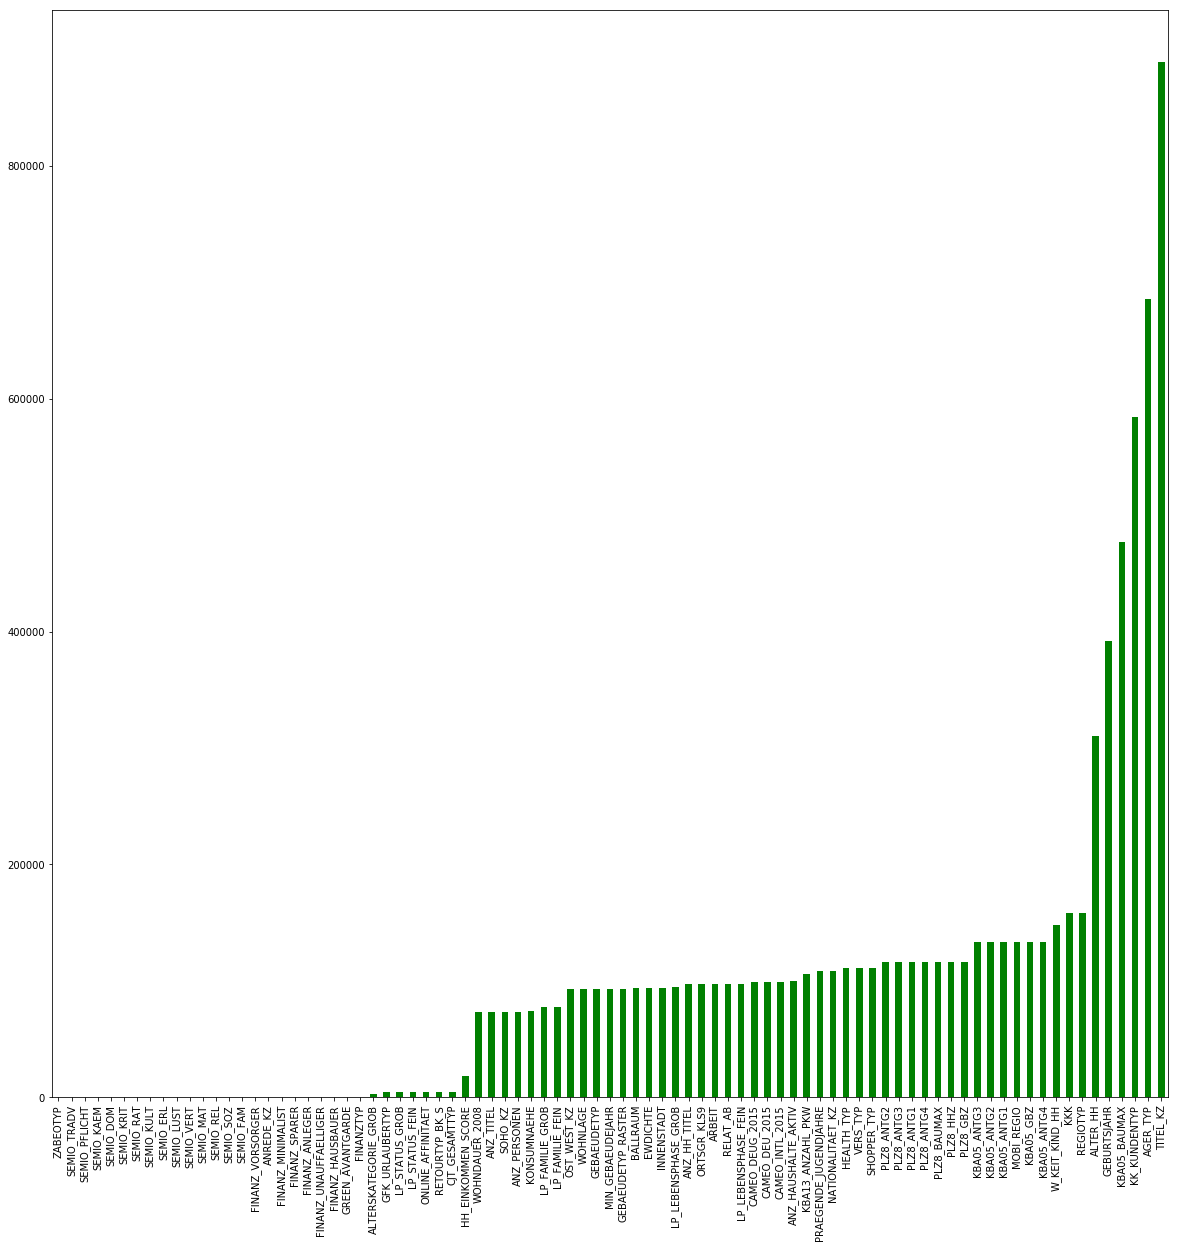

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.isnull().sum().sort_values().plot.bar(figsize=(20,20),color='green');

In [12]:
# 6 columns have significantly greter amounts of missing features
azdias.isnull().sum().sort_values()

ZABEOTYP                      0
SEMIO_TRADV                   0
SEMIO_PFLICHT                 0
SEMIO_KAEM                    0
SEMIO_DOM                     0
SEMIO_KRIT                    0
SEMIO_RAT                     0
SEMIO_KULT                    0
SEMIO_ERL                     0
SEMIO_LUST                    0
SEMIO_VERT                    0
SEMIO_MAT                     0
SEMIO_REL                     0
SEMIO_SOZ                     0
SEMIO_FAM                     0
FINANZ_VORSORGER              0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
FINANZTYP                     0
ALTERSKATEGORIE_GROB       2881
GFK_URLAUBERTYP            4854
LP_STATUS_GROB             4854
LP_STATUS_FEIN             4854
ONLINE_AFFINITAET          4854
RETOURTYP_BK_S             4854
                          ...  
CAMEO_IN

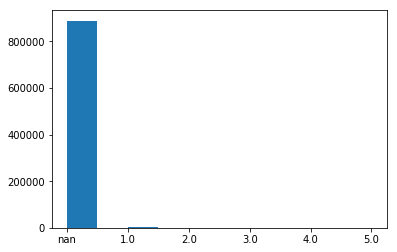

In [13]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(azdias[['TITEL_KZ']]);
#

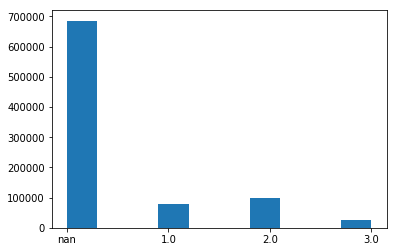

In [14]:
plt.hist(azdias[['AGER_TYP']]);

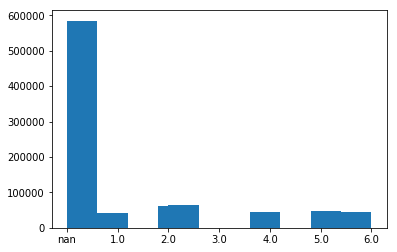

In [15]:
plt.hist(azdias[['KK_KUNDENTYP']]);


In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
d_cols =['ALTER_HH','GEBURTSJAHR' ,'KBA05_BAUMAX','KK_KUNDENTYP','AGER_TYP','TITEL_KZ']
azdias.drop(d_cols, axis=1,inplace=True)

In [17]:
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column


We drop columns TITEL_KZ and AGER_TYP because they are missing close to 80% of data. The other 4 also have relatively high amount of missing data (over 20%) which means it is unworkable.
On removing these 6 columns we will have access to cleaner more useable data
61 columns have missing values.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [18]:
# How much data is missing in each row of the dataset?
azdias.isnull().sum(axis=1).describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# We set a threshhold where if more than 10 columns of a row are missing we drop it from the data set
main_df = azdias.drop(azdias[azdias.isnull().sum(axis=1)>10].index)
missing_df = azdias.drop(azdias[azdias.isnull().sum(axis=1)<=10].index)

In [20]:
missing_df.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [22]:
main_df.shape[0],missing_df.shape[0]

(780153, 111068)

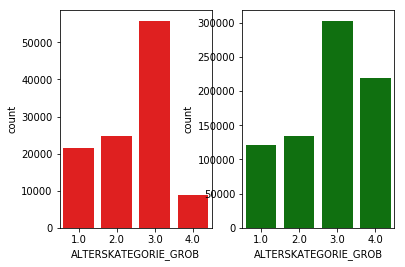

In [23]:
ax11 = plt.subplot(1,2,1)
sns.countplot(missing_df["ALTERSKATEGORIE_GROB"], ax=ax11,color="red")
ax12 = plt.subplot(1,2,2)
sns.countplot(main_df["ALTERSKATEGORIE_GROB"], ax=ax12,color="green")

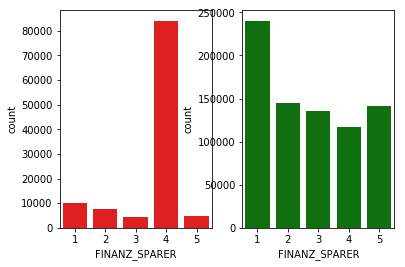

In [24]:
ax21 = plt.subplot(1,2,1)
sns.countplot(missing_df["FINANZ_SPARER"], ax=ax21,color="red")
ax22 = plt.subplot(1,2,2)
sns.countplot(main_df["FINANZ_SPARER"], ax=ax22,color="green")

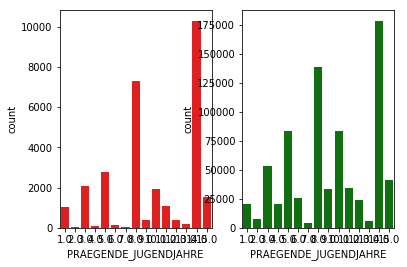

In [25]:
ax31 = plt.subplot(1,2,1)
sns.countplot(missing_df["PRAEGENDE_JUGENDJAHRE"], ax=ax31,color="red")
ax32 = plt.subplot(1,2,2)
sns.countplot(main_df["PRAEGENDE_JUGENDJAHRE"], ax=ax32,color="green")

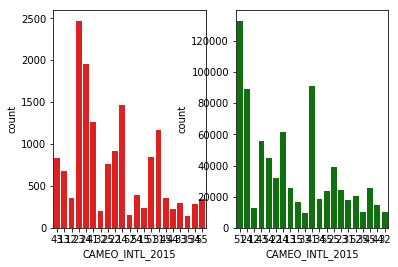

In [26]:
ax41 = plt.subplot(1,2,1)
sns.countplot(missing_df["CAMEO_INTL_2015"], ax=ax41,color="red")
ax42 = plt.subplot(1,2,2)
sns.countplot(main_df["CAMEO_INTL_2015"], ax=ax42,color="green")

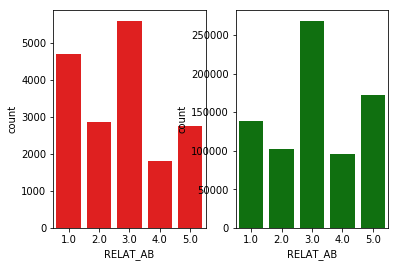

In [27]:
ax51 = plt.subplot(1,2,1)
sns.countplot(missing_df["RELAT_AB"], ax=ax51,color="red")
ax52 = plt.subplot(1,2,2)
sns.countplot(main_df["RELAT_AB"], ax=ax52,color="green")

#### Discussion 1.1.3: Assess Missing Data in Each Row

A large number of rows were dropped, this ensures our clustering algorithm will be able to better cluster the users.
Around 20% of all rows contain more than 10 missing values, this suggests we need to better collect data.
But the remaining number of rows is still large and sufficient to train our model
The large amount of missing data suggests that data wasn't collected properly/holistically

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [28]:
# How many features are there of each data type?
feat_info.groupby('type').count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


In [29]:
feat_info[feat_info['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
copy = main_df.copy()

In [31]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# Deleting features we have already deleted
for i in d_cols:
    feat_info = feat_info[feat_info.attribute != i]


In [32]:
feat_info.shape

(79, 4)

In [33]:
# Re-encode categorical variable(s) to be kept in the analysis.
feat_info.shape

(79, 4)

In [34]:
categorical_variables = main_df[feat_info[feat_info['type'] == 'categorical']['attribute']]

In [35]:
binary = []
multivar = []
for x in categorical_variables:
    if len(categorical_variables[x].value_counts()) == 2:
        binary.append(x)
    else:
        multivar.append(x)

In [36]:
multivar

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [37]:
binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [38]:
# Finding non numerical binary column
main_df.ANREDE_KZ.value_counts()

2    406643
1    373510
Name: ANREDE_KZ, dtype: int64

In [39]:
main_df.OST_WEST_KZ.value_counts()#This is non-binary numerical

W    614719
O    165434
Name: OST_WEST_KZ, dtype: int64

In [40]:
main_df['OST_WEST_KZ'] = main_df['OST_WEST_KZ'].map({'W': 1, 'O': 0})

In [41]:
main_df = pd.get_dummies(main_df, columns=multivar)

In [42]:
main_df.shape

(780153, 194)

#### Discussion 1.2.1: Re-Encode Categorical Features

There are more multivariable categorical features which need to be transformed using dummy variables.
OST_WEST_KZ is a unique feature that needs to be encoded since it does not take numerical values.This column is then encoded using numerical values.
By recoding these categorical variables, we ensure our clustering algorithm will perform better, since they perform better with binary categorical variables. This should ensure a better accuracy during clustering


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [43]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variable
main_df['PRAEGENDE_JUGENDJAHRE'].head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

##### From Data_Dictionary.md
### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [44]:
avantgarde=[]
for x in main_df['PRAEGENDE_JUGENDJAHRE']:
    if x in [1,3,5,8,10,12,14]:
        avantgarde.append(0) # Value 0 denotes 'Mainstream'
    elif x in [2,4,6,7,9,11,13,15]:
        avantgarde.append(1) # Value 1 denotes 'Avantgarde'
    else:
        avantgarde.append(np.nan)
a = pd.Series(avantgarde)
main_df['AVANTGARDE'] = a.values
main_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,AVANTGARDE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1,0,0,0,0,0,0,0,0,0.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,1.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,0.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,1,0,0,0,0,0,0,0.0


In [45]:
#east_west = []
#for x in copy['PRAEGENDE_JUGENDJAHRE']:
    #if x in [7,12,13]:
        #east_west.append('East')
    #if x in [6,10,11]:
        #east_west.append('West')
    #else:
        #east_west.append(np.nan)   


In [46]:
main_df['year'] = main_df['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6})

In [47]:
main_df.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)

In [48]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [49]:
main_df['CAMEO_INTL_2015'].value_counts()

51    132853
41     91071
24     89200
14     61422
43     55836
54     45004
25     38860
22     32235
45     25771
13     25659
23     24280
55     23609
52     20388
34     18237
31     17853
15     16735
44     14593
12     12890
35     10212
32     10153
33      9636
Name: CAMEO_INTL_2015, dtype: int64

In [50]:
#Perform operation similar to previous column
cameo = []


for x in main_df['CAMEO_INTL_2015']:
    x=float(x)
    if 50 < x < 56:
        cameo.append(1)#Wealthy
    elif 40 < x < 46:
        cameo.append(2)#Affluent
    elif 30 < x < 36:
        cameo.append(3)#Comfortable
    elif 20 < x < 26:
        cameo.append(4)#Less Affluent
    elif 10 < x < 16:
        cameo.append(5)#Poor
    else:
        cameo.append(np.nan)

b = pd.Series(cameo)
main_df['CAMEO_WEALTH'] = b.values
main_df.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,AVANTGARDE,year,CAMEO_WEALTH
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0,0.0,6.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,1.0,6.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0.0,4.0,5.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0.0,4.0,2.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1,0,0,0,0,0,0,0.0,2.0,1.0


In [51]:
cameo_lif = []

for x in main_df['CAMEO_INTL_2015']:
    x= float(x)
    if x % 10 == 1:
        cameo_lif.append(1)
    elif x % 10 == 2:
        cameo_lif.append(2)
    elif x % 10 == 3:
        cameo_lif.append(3)
    elif x % 10 == 4:
        cameo_lif.append(4)
    elif x % 10 == 5:
        cameo_lif.append(5)
    else:
        cameo_lif.append(np.nan)
c= pd.Series(cameo_lif)
main_df['CAMEO_LIFE'] = c.values
main_df.head()        


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,AVANTGARDE,year,CAMEO_WEALTH,CAMEO_LIFE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0.0,6.0,1.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,1.0,6.0,4.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0.0,4.0,5.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0.0,4.0,2.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0.0,2.0,1.0,4.0


In [52]:
main_df.drop(['CAMEO_INTL_2015'],axis=1,inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [53]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
engineered =["CAMEO_LIFE","CAMEO_WEALTH","year","AVANTGARDE"]
main_df = pd.get_dummies(main_df, columns=engineered)


In [54]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
main_df.shape


(780153, 210)

In [55]:
copy = main_df.copy()

In [56]:
copy.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_WEALTH_4.0,CAMEO_WEALTH_5.0,year_1.0,year_2.0,year_3.0,year_4.0,year_5.0,year_6.0,AVANTGARDE_0.0,AVANTGARDE_1.0
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,0,1,1,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1,0,0,0,0,0,0,1,0,1
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,1,0,0,0,1,0,0,1,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,1,0,0,1,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,0,0,1,0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [57]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')
    
    # convert missing value codes into NaNs, ...
    
    for i,V in enumerate(df.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        column_name = V[0]
        missing_unknown = missing_unknown[1:-1].split(',')
        if missing_unknown != ['']:
            hold = []
            for x in missing_unknown:
                if x in ['X','XX']:
                    hold.append(x)
                else:
                    hold.append(int(x))
            df[column_name] = df[column_name].replace(hold,np.nan)
    
    # remove selected columns and rows, ...
    #d_cols =['ALTER_HH','GEBURTSJAHR' ,'KBA05_BAUMAX','KK_KUNDENTYP','AGER_TYP','TITEL_KZ']
    #df.drop(d_cols, axis=1,inplace=True)
    #df = df.drop(df[df.isnull().sum(axis=1)<=10].index)
    #df = df[df.index.isin(missing_row_data[missing_row_data < 10].index)]
    df = df.drop(df[df.isnull().sum(axis=1)>10].index)
    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 0})
    multivar = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ',
                    'SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']
    df = pd.get_dummies(df, columns=multivar)
    
    avantgarde=[]
    for x in df['PRAEGENDE_JUGENDJAHRE']:
        if x in [1,3,5,8,10,12,14]:
            avantgarde.append(0) # Value 0 denotes 'Mainstream'
        elif x in [2,4,6,7,9,11,13,15]:
            avantgarde.append(1) # Value 1 denotes 'Avantgarde'
        else:
            avantgarde.append(np.nan)
            
            
    a = pd.Series(avantgarde)
    df['AVANTGARDE'] = a.values
    df['year'] = df['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6})
    cameo = []


    for x in df['CAMEO_INTL_2015']:
        x=float(x)
        if 50 < x < 56:
            cameo.append(1)#Wealthy
        elif 40 < x < 46:
            cameo.append(2)#Affluent
        elif 30 < x < 36:
            cameo.append(3)#Comfortable
        elif 20 < x < 26:
            cameo.append(4)#Less Affluent
        elif 10 < x < 16:
            cameo.append(5)#Poor
        else:
            cameo.append(np.nan)

    b = pd.Series(cameo)
    df['CAMEO_WEALTH'] = b.values
    cameo_lif = []

    for x in df['CAMEO_INTL_2015']:
        x= float(x)
        if x % 10 == 1:
            cameo_lif.append(1)
        elif x % 10 == 2:
            cameo_lif.append(2)
        elif x % 10 == 3:
            cameo_lif.append(3)
        elif x % 10 == 4:
            cameo_lif.append(4)
        elif x % 10 == 5:
            cameo_lif.append(5)
        else:
            cameo_lif.append(np.nan)
    c= pd.Series(cameo_lif)
    df['CAMEO_LIFE'] = c.values
    engineered =["CAMEO_LIFE","CAMEO_WEALTH","year","AVANTGARDE"]
    df = pd.get_dummies(df, columns=engineered)
    
    # Return the cleaned dataframe.
    return df
    

from sklearn.preprocessing import Imputer, StandardScaler
imputer = Imputer(missing_values='NaN',strategy='median',axis=0)
main_df = imputer.fit_transform(main_df)
main_df = pd.DataFrame(main_df)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [58]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
main_df.isnull().sum()

ALTERSKATEGORIE_GROB      2625
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP               34524
LP_LEBENSPHASE_FEIN      46574
LP_LEBENSPHASE_GROB      43894
RETOURTYP_BK_S            3834
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
SOHO_KZ                      0
VERS_TYP                 34524
ANZ_PERSONEN                 0
                         ...  
CAMEO_DEU_2015_7C            0
CAMEO_DE

In [59]:
from sklearn.preprocessing import Imputer, StandardScaler
imputer = Imputer(missing_values='NaN',strategy='median',axis=0)
main_df = imputer.fit_transform(main_df)
main_df = pd.DataFrame(main_df)

In [60]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
main_df = scaler.fit_transform(main_df)
main_df = pd.DataFrame(main_df)

In [61]:
main_df.isnull().sum()

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
180    0
181    0
182    0
183    0
184    0
185    0
186    0
187    0
188    0
189    0
190    0
191    0
192    0
193    0
194    0
195    0
196    0
197    0
198    0
199    0
200    0
201    0
202    0
203    0
204    0
205    0
206    0
207    0
208    0
209    0
Length: 210, dtype: int64

### Discussion 2.1: Apply Feature Scaling

The data set still contains a large amount of missing data, so we impute it using the Imputer. We impute it using the median of the value of the column. Median is preffered over the Mean since the mean is significantly affected by Outliers.
We then perform feature scaling since this is a significant important step that greatly improves the efficiency of the clustering algorithm.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [62]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA(n_components=150)
pca_X = pca.fit_transform(main_df)

In [63]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 30))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

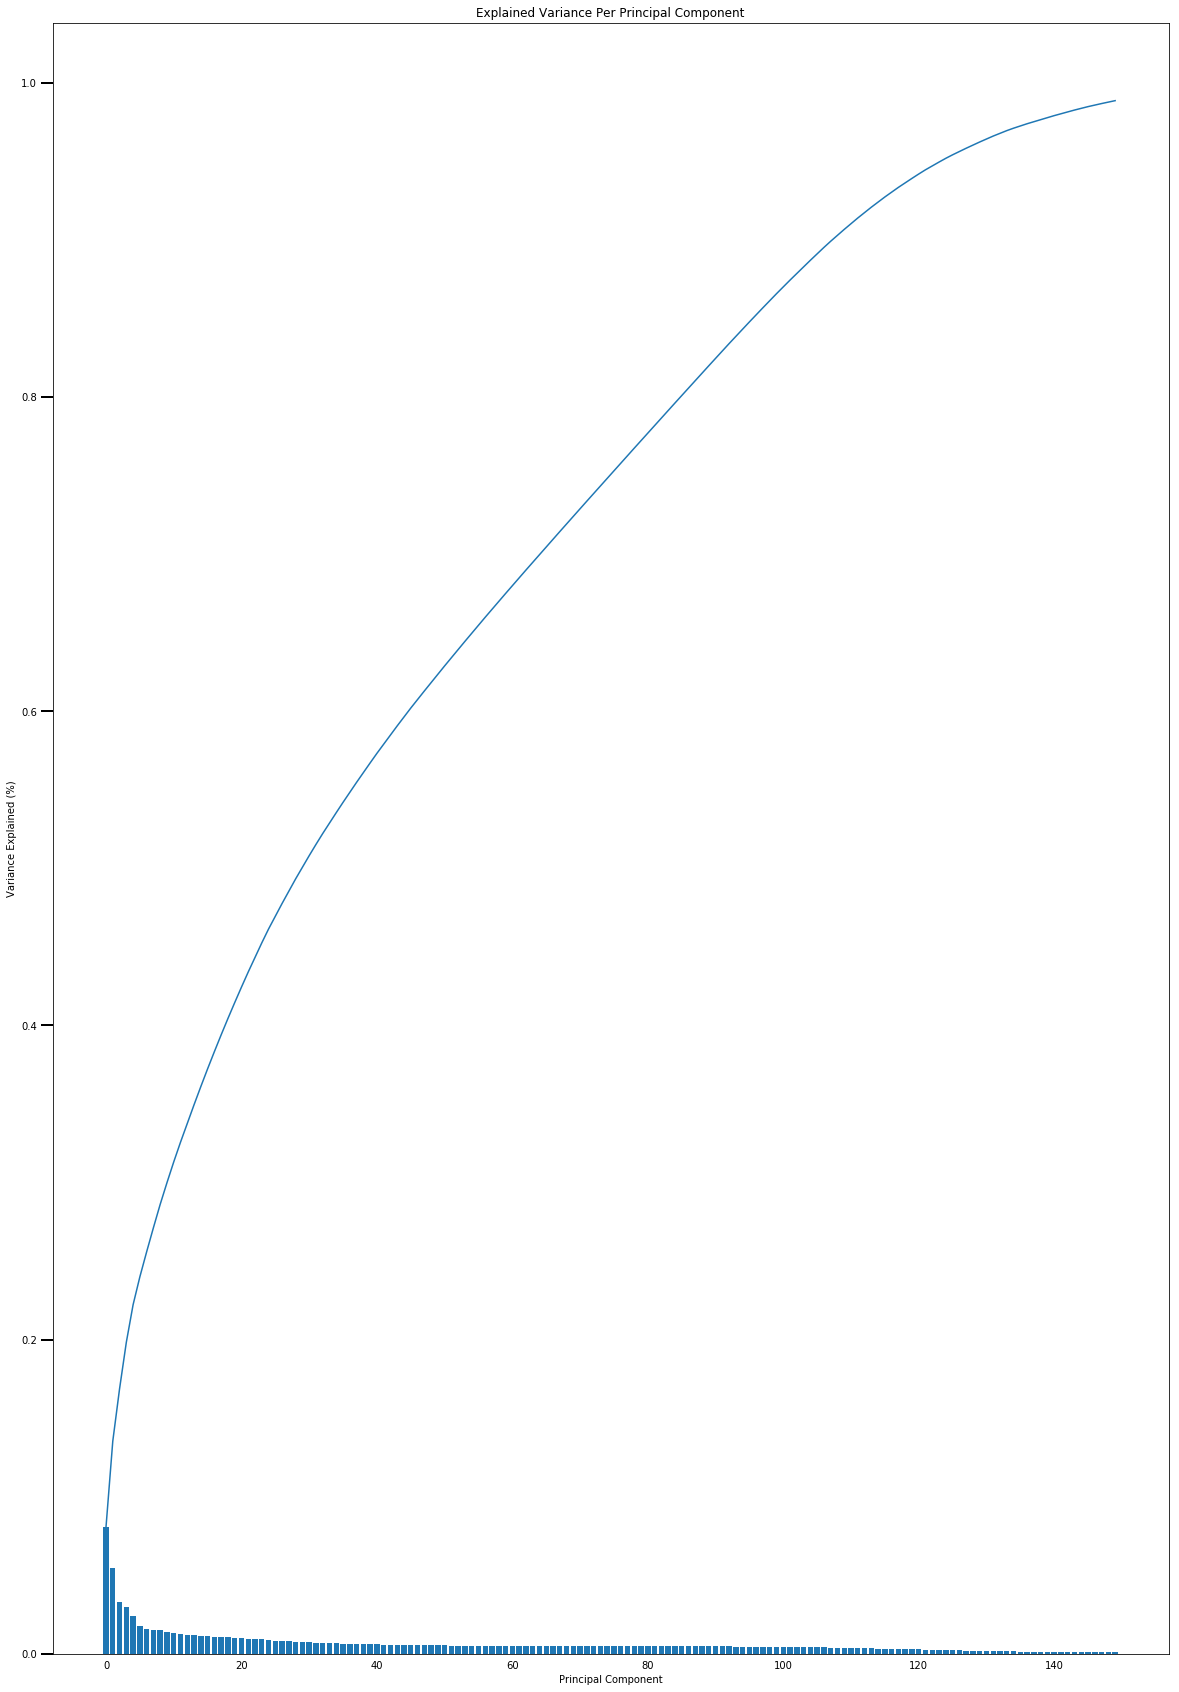

In [64]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

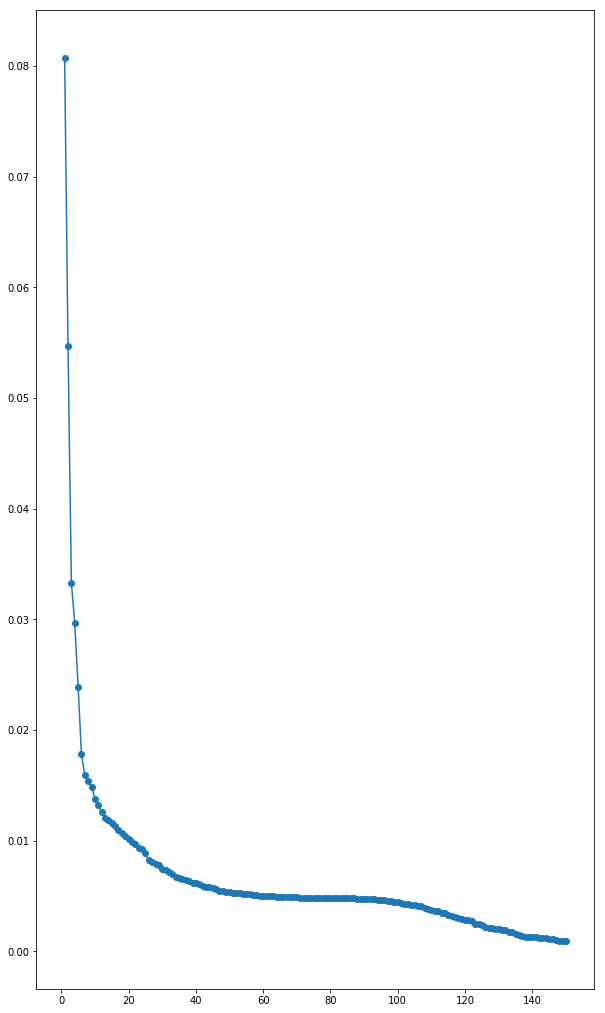

In [65]:
# Re-apply PCA to the data while selecting for number of components to retain.
plt.figure(figsize=(10,18))
plt.plot(list(range(1, pca_X.shape[1] + 1)), pca.explained_variance_ratio_)
plt.scatter(list(range(1, pca_X.shape[1]+1)), pca.explained_variance_ratio_)
plt.show()

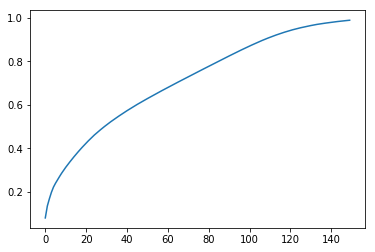

In [66]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [67]:
pca = PCA(n_components=80)
pca_X = pca.fit_transform(main_df)
pca_df = pd.DataFrame(data=pca_X)

In [68]:
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,4.567776,-4.339717,-2.539491,2.315476,0.902509,-0.240064,0.466447,-1.362286,2.350419,0.389643,...,-0.975120,-0.509020,1.462177,-1.202278,0.680697,-0.383914,0.776679,-0.007643,-1.062537,-0.422725
1,-0.509056,-0.775333,-2.755374,1.788542,-4.617793,-1.042850,3.500565,-1.979330,-0.722934,0.322631,...,-0.495497,0.196534,0.546785,-0.524444,0.212691,0.138938,0.037604,0.286300,-0.105166,0.903026
2,-4.787316,1.847956,-2.117454,-1.818037,0.288591,-2.118248,-3.820130,2.380166,1.731133,0.431170,...,-1.517052,-0.882704,-0.414155,1.082339,-1.333435,0.041267,-0.729673,0.441227,0.238593,1.333314
3,-0.738731,0.282150,3.197826,0.567780,3.359603,5.277536,-0.452913,-1.133829,-1.422176,-1.687299,...,0.433054,0.685001,-0.283518,-0.115418,0.142795,-0.150577,0.275223,0.072848,-0.425181,-0.340432
4,-0.381647,-0.756852,-2.283372,-3.235725,-1.658854,-0.692763,0.364079,-2.140506,2.607720,-0.093016,...,0.201560,-1.537787,-0.048346,1.072886,-0.223860,-0.133510,-0.284037,0.018274,0.714123,1.060445


### Discussion 2.2: Perform Dimensionality Reduction

We first run PCA with 150 components and plot the scree plot. This plot shows us that at around the 80 features point we still have around 80% of the information. This is a good trade of between runtime and accuracy.
Therefore we store this into pcd_df which now contains 80 columns.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [69]:
def map_weight(df, component):
    pca_df = pd.DataFrame(pca.components_, columns=list(copy.columns))
    pca_component = pd.DataFrame(pca_df.iloc[component])
    print(pca_component.sort_values(component, ascending=False))

In [70]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
map_weight(main_df,0)

                             0
LP_STATUS_GROB_1.0    0.185008
HH_EINKOMMEN_SCORE    0.177969
PLZ8_ANTG3            0.175137
PLZ8_ANTG4            0.170044
PLZ8_BAUMAX           0.165534
ORTSGR_KLS9           0.147605
EWDICHTE              0.146173
CAMEO_WEALTH_1.0      0.145876
FINANZ_HAUSBAUER      0.144314
CAMEO_LIFE_1.0        0.136121
LP_STATUS_FEIN_1.0    0.124268
KBA05_ANTG4           0.123722
PLZ8_ANTG2            0.119803
KBA05_ANTG3           0.111594
ANZ_HAUSHALTE_AKTIV   0.110566
CAMEO_DEUG_2015_9     0.109095
ARBEIT                0.109041
LP_STATUS_FEIN_2.0    0.103714
RELAT_AB              0.102184
FINANZTYP_1           0.099399
FINANZ_SPARER         0.098103
LP_FAMILIE_FEIN_1.0   0.095766
LP_FAMILIE_GROB_1.0   0.095766
CAMEO_DEUG_2015_8     0.090426
AVANTGARDE_0.0        0.087257
ZABEOTYP_5            0.069836
SEMIO_PFLICHT         0.068853
SEMIO_REL             0.065343
GEBAEUDETYP_3.0       0.063861
CAMEO_DEU_2015_8A     0.062540
...                        ...
CAMEO_DE

In [71]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weight(main_df, 1)

                              1
ALTERSKATEGORIE_GROB   0.234215
FINANZ_VORSORGER       0.221346
ZABEOTYP_3             0.196176
SEMIO_ERL              0.177297
SEMIO_LUST             0.163017
RETOURTYP_BK_S         0.155659
W_KEIT_KIND_HH         0.123964
year_3.0               0.116423
CJT_GESAMTTYP_2.0      0.107934
year_2.0               0.104843
FINANZ_MINIMALIST      0.103264
FINANZTYP_5            0.097196
FINANZTYP_2            0.093860
LP_STATUS_FEIN_1.0     0.085768
SHOPPER_TYP_3.0        0.075054
FINANZ_HAUSBAUER       0.070458
CJT_GESAMTTYP_1.0      0.069852
SEMIO_KRIT             0.069314
NATIONALITAET_KZ_1.0   0.069259
FINANZTYP_6            0.068955
year_1.0               0.066092
year_4.0               0.063292
LP_FAMILIE_FEIN_1.0    0.056865
LP_FAMILIE_GROB_1.0    0.056865
GFK_URLAUBERTYP_4.0    0.056671
WOHNDAUER_2008         0.055697
EWDICHTE               0.053573
PLZ8_ANTG3             0.052955
ORTSGR_KLS9            0.052491
SEMIO_KAEM             0.050008
...     

In [72]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weight(main_df, 2)

                            2
SEMIO_VERT           0.282793
SEMIO_SOZ            0.234410
SEMIO_FAM            0.230407
SEMIO_KULT           0.220696
AVANTGARDE_1.0       0.151858
GREEN_AVANTGARDE     0.151858
FINANZTYP_5          0.142120
ZABEOTYP_1           0.128305
FINANZ_MINIMALIST    0.118645
LP_STATUS_FEIN_10.0  0.114294
LP_STATUS_GROB_5.0   0.114294
ORTSGR_KLS9          0.113665
EWDICHTE             0.113348
SHOPPER_TYP_0.0      0.105745
SEMIO_REL            0.105004
SEMIO_MAT            0.082140
PLZ8_ANTG3           0.074028
PLZ8_ANTG4           0.072587
PLZ8_BAUMAX          0.071231
RETOURTYP_BK_S       0.065262
RELAT_AB             0.055698
LP_STATUS_FEIN_3.0   0.055369
PLZ8_ANTG2           0.055068
LP_LEBENSPHASE_FEIN  0.053001
LP_LEBENSPHASE_GROB  0.052421
CAMEO_WEALTH_5.0     0.050764
ARBEIT               0.050487
ANZ_PERSONEN         0.048665
CAMEO_DEUG_2015_1    0.048060
LP_FAMILIE_GROB_5.0  0.045858
...                       ...
FINANZ_SPARER       -0.043342
LP_FAMILIE

In [73]:
pca

PCA(copy=True, iterated_power='auto', n_components=80, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Larger positive values suggest a positive correlation between the two components(one goes up, other goes up), while large negative values suggest a negative correlation(one goes up, other goes down). While 0 suggests lack of correlation ie change in one component does not affect the other component.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

evaluating for 1 clusters
evaluating for 2 clusters
evaluating for 3 clusters
evaluating for 4 clusters
evaluating for 5 clusters
evaluating for 6 clusters
evaluating for 7 clusters
evaluating for 8 clusters
evaluating for 9 clusters
evaluating for 10 clusters
evaluating for 11 clusters
evaluating for 12 clusters
evaluating for 13 clusters
evaluating for 14 clusters
evaluating for 15 clusters
evaluating for 16 clusters
evaluating for 17 clusters
evaluating for 18 clusters
evaluating for 19 clusters
evaluating for 20 clusters


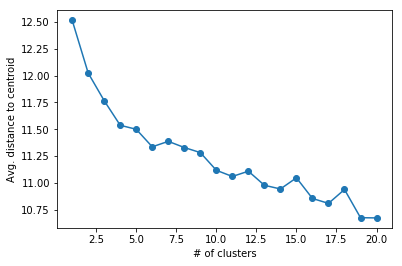

In [74]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
#cluster_nums = [1, 2, 3, 4]
cluster_nums = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
distances = []

for c in cluster_nums:
    print('evaluating for {} clusters'.format(c))
    
    # run k-means clustering on the data and...
    kmeans = MiniBatchKMeans(n_clusters=c)
    
    preds = kmeans.fit_predict(pca_df)
    #print(preds)
    # compute the average within-cluster distances.
    pred_centroids = kmeans.cluster_centers_
    #print(pred_centroids)
    centers = pred_centroids[preds]
    #print(centers)
    distance = np.sqrt(((pca_df - centers) ** 2).sum(axis = 1)).mean()
    distances.append(distance)
    
plt.plot(cluster_nums, distances, '-o')
plt.ylabel('Avg. distance to centroid')
plt.xlabel('# of clusters')
plt.savefig('distance_to_centroid.png')

In [75]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.


In [76]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=13)
model = kmeans.fit(pca_df)
prediction_azdias = model.predict(pca_df)

### Discussion 3.1: Apply Clustering to General Population

Since we used mini batch Kmeans,it may not be as accurate. But there appears to be a clear elbow at around the 13 point, so we use it to Cluster customers into 13 diffrent sets

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [77]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [78]:
customers.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [79]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)

In [80]:
customers_clean.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,...,CAMEO_WEALTH_4.0,CAMEO_WEALTH_5.0,year_1.0,year_2.0,year_3.0,year_4.0,year_5.0,year_6.0,AVANTGARDE_0.0,AVANTGARDE_1.0
0,2.0,4.0,1,5,1,5,1,2,2,NaN,...,0,1,0,1,0,0,0,0,0,1
2,NaN,4.0,2,5,1,5,1,4,4,NaN,...,0,0,0,1,0,0,0,0,0,1
3,1.0,4.0,1,5,1,5,2,1,2,NaN,...,1,0,1,0,0,0,0,0,1,0
4,NaN,3.0,1,3,1,4,4,5,2,1960.0,...,0,0,0,0,0,1,0,0,1,0
5,1.0,3.0,1,5,1,5,1,2,3,NaN,...,0,0,0,1,0,0,0,0,0,1


In [88]:
customers_clean.drop(['ALTER_HH','GEBURTSJAHR' ,'KBA05_BAUMAX','KK_KUNDENTYP','AGER_TYP','TITEL_KZ'],axis=1,inplace=True)

In [89]:
a = np.intersect1d(customers_clean.columns, copy.columns)


In [90]:
print(len(a))

209


In [91]:
for i in a:
    if i not in copy.columns:
        print(i)

In [92]:
i

'year_6.0'

In [96]:
customers_clean.shape,copy.shape

((132432, 210), (780153, 210))

In [95]:
customers_clean.drop(['year_6.0'],axis=1,inplace=True)

In [97]:

imputer = Imputer(missing_values='NaN',strategy='median',axis=0)
customers_clean = imputer.fit_transform(customers_clean)
customers_clean = pd.DataFrame(customers_clean)

In [98]:
scaler = StandardScaler()
customers_clean = scaler.fit_transform(customers_clean)
customers_clean= pd.DataFrame(customers_clean)

In [99]:
pca = PCA(n_components=80)
pca_X = pca.fit_transform(customers_clean)
cust_df = pd.DataFrame(data=pca_X)

In [100]:
kmeans = KMeans(n_clusters=13)
model = kmeans.fit(cust_df)
prediction_customer = model.predict(cust_df)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [101]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
prediction_customer = pd.Series(prediction_customer)


In [102]:
prediction_customer.value_counts().sort_index()

0     19405
1      8976
2     12828
3     11379
4      9559
5     13789
6     11705
7      5030
8     11201
9     10322
10     3890
11     8089
12     6259
dtype: int64

In [103]:
prediction_azdias = pd.Series(prediction_azdias)
prediction_azdias.value_counts().sort_index()

0     60212
1     73095
2     46186
3     78716
4     64044
5     89289
6     50586
7     32804
8     61542
9     72047
10    57314
11    60357
12    33961
dtype: int64

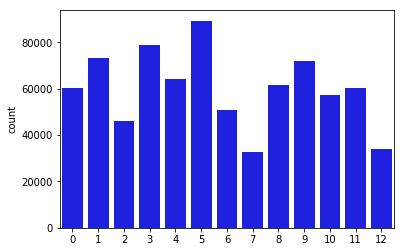

In [104]:
sns.countplot(prediction_azdias,color="blue")

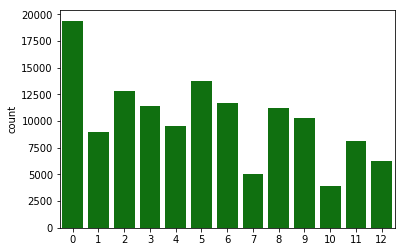

In [105]:
sns.countplot(prediction_customer,color="green")

In [106]:
gen_pop=[]
cust_pop=[]
x =[0,1,2,3,4,5,6,7,8,9,10,11,12]
for i in range(13):
    gen_pop.append((prediction_azdias == i).sum()/len(prediction_azdias))
    cust_pop.append((prediction_customer == i).sum()/len(prediction_customer))
    
df1 = pd.DataFrame({'cluster' : x, 'gen_pop' : gen_pop, 'cust_pop':cust_pop})

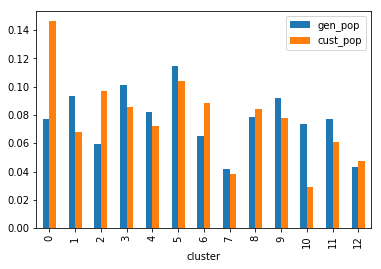

In [107]:
df1.plot(x='cluster',y=['gen_pop','cust_pop'],kind='bar')

In [108]:
main_df.head()

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
0,-1.767651,0.958395,-1.488140,1.539080,-1.045251,1.467273,0.980071,1.326876,-0.531199,1.088920,...,-0.556695,-0.419415,-0.191795,-0.322365,-0.411822,-0.531564,-0.484098,1.598504,0.583521,-0.531199
1,0.198089,0.958395,-1.488140,0.866538,-1.771610,-0.569041,0.262544,1.326876,1.882535,1.088920,...,1.796317,-0.419415,-0.191795,-0.322365,-0.411822,-0.531564,-0.484098,1.598504,-1.713734,1.882535
2,1.180959,0.958395,0.688928,-0.478545,1.133828,-0.569041,-1.172510,-0.817895,-0.531199,-0.263472,...,-0.556695,2.384276,-0.191795,-0.322365,-0.411822,1.881242,-0.484098,-0.625585,0.583521,-0.531199
3,0.198089,-1.043411,0.688928,0.193996,0.407468,-1.247812,0.262544,-0.817895,-0.531199,1.088920,...,-0.556695,-0.419415,-0.191795,-0.322365,-0.411822,1.881242,-0.484098,-0.625585,0.583521,-0.531199
4,-1.767651,0.958395,-0.036761,-1.151087,1.133828,-0.569041,-0.454983,1.326876,-0.531199,1.088920,...,-0.556695,-0.419415,-0.191795,3.102072,-0.411822,-0.531564,-0.484098,-0.625585,0.583521,-0.531199


In [118]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Cluster 0,2 and 6 are overrepresented among customers


In [110]:
len(centroid6)

210

data = scaler.inverse_transform(pca.inverse_transform(customers_clean[np.where(prediction_customer==4)])).round()
df = pd.DataFrame(data=data,
          index=np.array(range(0, data.shape[0])),
          columns=copy.columns)
df.head(10)

In [127]:
c0 = kmeans.cluster_centers_[0]
c0 = pd.Series(c0)
c0.sort_values(ascending=False, inplace=True)
c0.head(5)

1     1.845414
5     0.481871
25    0.408445
10    0.377259
18    0.374065
dtype: float64

In [128]:
c0 = scaler.inverse_transform(pca.inverse_transform(c0))
c0 = pd.Series(c0).round()
c0.index = copy.columns
c0

ALTERSKATEGORIE_GROB      3.0
ANREDE_KZ                 1.0
FINANZ_MINIMALIST         4.0
FINANZ_SPARER             2.0
FINANZ_VORSORGER          4.0
FINANZ_ANLEGER            2.0
FINANZ_UNAUFFAELLIGER     2.0
FINANZ_HAUSBAUER          3.0
GREEN_AVANTGARDE          0.0
HEALTH_TYP                2.0
LP_LEBENSPHASE_FEIN      23.0
LP_LEBENSPHASE_GROB       7.0
RETOURTYP_BK_S            6.0
SEMIO_SOZ                 4.0
SEMIO_FAM                 4.0
SEMIO_REL                 4.0
SEMIO_MAT                 3.0
SEMIO_VERT                3.0
SEMIO_LUST                5.0
SEMIO_ERL                 5.0
SEMIO_KULT                5.0
SEMIO_RAT                 4.0
SEMIO_KRIT                3.0
SEMIO_DOM                 4.0
SEMIO_KAEM                4.0
SEMIO_PFLICHT             4.0
SEMIO_TRADV               3.0
SOHO_KZ                   3.0
VERS_TYP                  0.0
ANZ_PERSONEN              2.0
                         ... 
CAMEO_DEU_2015_7C        -0.0
CAMEO_DEU_2015_7D         0.0
CAMEO_DEU_

In [123]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# Cluster 11 is underrepresented
c10 = kmeans.cluster_centers_[10]
c10 = pd.Series(c10)
c10.sort_values(ascending=False, inplace=True)
c10.head(5)

1     6.506425
2     4.078789
0     3.731473
16    2.195470
15    1.980376
dtype: float64

In [124]:
c10 = scaler.inverse_transform(pca.inverse_transform(c10))
c10 = pd.Series(c10).round()
c10.index = copy.columns
c10

ALTERSKATEGORIE_GROB      3.0
ANREDE_KZ                 2.0
FINANZ_MINIMALIST         2.0
FINANZ_SPARER             3.0
FINANZ_VORSORGER          3.0
FINANZ_ANLEGER            3.0
FINANZ_UNAUFFAELLIGER     3.0
FINANZ_HAUSBAUER          4.0
GREEN_AVANTGARDE          0.0
HEALTH_TYP                2.0
LP_LEBENSPHASE_FEIN      25.0
LP_LEBENSPHASE_GROB       8.0
RETOURTYP_BK_S           10.0
SEMIO_SOZ                 4.0
SEMIO_FAM                 4.0
SEMIO_REL                 3.0
SEMIO_MAT                 3.0
SEMIO_VERT                4.0
SEMIO_LUST                3.0
SEMIO_ERL                 4.0
SEMIO_KULT                6.0
SEMIO_RAT                 3.0
SEMIO_KRIT                4.0
SEMIO_DOM                 5.0
SEMIO_KAEM                6.0
SEMIO_PFLICHT             6.0
SEMIO_TRADV               4.0
SOHO_KZ                   4.0
VERS_TYP                  0.0
ANZ_PERSONEN              2.0
                         ... 
CAMEO_DEU_2015_7C        -0.0
CAMEO_DEU_2015_7D         0.0
CAMEO_DEU_

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Cluster 2 is overrepresented and represents people between the age of 45-60, have low financial intrest. They also constitue home owners. They also belong to high income households. This suggests that the older wealthier people dispropotionately use the service.

Cluster 10 is underrepresented and represents younger portions of the population. They are less wealthy than Cluster 2. This could be due to generational diffrences since younger people are less likely to use the mail order service.

This crucial information allows the company to avoid people in cluster 10 while targeting people in custers 0 and 2.
This will result in optimization of marketing spending and therefore better profits in the long run.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.